In [1]:
# Core python libraries
import csv
import re
import math
import os
import time

# External libraries.
import nltk
import numpy
import pandas
import scipy
import sklearn
import tempfile


# Tensorflow and related.
import tensorflow as tf


# Plotting
import matplotlib.pyplot as plt

# So you know when this code block finishes.
print ("Done")

Done


In [2]:
#TODO (max): make a library that does all this preprocessing
data = pandas.read_csv('data/train.csv') #Can read a subset. First nrows of the total.
LABEL_COLUMN = "LogSalaryNormalized"

TEST_SIZE = .2

binomial = False

if binomial:
    # This is for use in exploring logistic regression. Need a binomial outcome variable
    LABEL_COLUMN = "HighPayingJobs"
    data[LABEL_COLUMN] = (data["SalaryNormalized"].apply(lambda x: x >= 30000)).astype(int)

print(len(data))

171386


In [3]:
# sklearn.cross_validation has been replaced with model_selection.
X_train_index, X_test_index, Y_train, Y_test = sklearn.model_selection.train_test_split(
    data.index, data[LABEL_COLUMN], test_size=TEST_SIZE, random_state=42)

# Keep train and test as pandas dataframes.
X_train = data.iloc[X_train_index]
X_test = data.iloc[X_test_index]

yb_train = numpy.array(X_train[LABEL_COLUMN].astype(numpy.float32))
yb_test= numpy.array(X_test[LABEL_COLUMN].astype(numpy.float32))

# Uncomment this next line if you want to check the data.
#print(data.head())

print ("Done")

Done


In [5]:
target_column ='FullDescriptionWithTitle'
target_column = 'Title'

stemmer = nltk.PorterStemmer()

def process_cell(cell, lower_case=True):
    try:
        value = " ".join([stemmer.stem(word) for word in cell.split(" ")])
    except IndexError:
        value = cell
        print("Error processing: %s" % value)
    if lower_case:
        value = value.lower()
    #print(value)
    return value 

def process_text_column(data_frame, column, stemmer):
    data_frame['%sStemmed' % column] = data_frame[column].apply(
        lambda cell: process_cell(cell))
    return data_frame['%sStemmed' % column]



In [6]:
x_train_text = process_text_column(X_train, target_column, stemmer)
x_test_text = process_text_column(X_test, target_column, stemmer)

# Look here for a tutorial https://medium.com/@ilblackdragon/tensorflow-text-classification-615198df9231
max_document_length = max([len(x.split(" ")) for x in x_train_text])

min_word_frequency = 10

vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(max_document_length, min_frequency=min_word_frequency)
x_train = numpy.array(list(vocab_processor.fit_transform(x_train_text)))
print("x_train shape: %s, %s" % x_train.shape)
x_test = numpy.array(list(vocab_processor.transform(x_test_text)))
print("x_test shape: %s, %s" % x_test.shape)
n_words = len(vocab_processor.vocabulary_)
print('Total distinct words: %d' % n_words)

# Try looking at https://github.com/nfmcclure/tensorflow_cookbook/blob/master/07_Natural_Language_Processing/02_Working_with_Bag_of_Words/02_bag_of_words.py


Error processing: Alternative Investment Specialist Dubai **** K AED per Month
Error processing: Sales Manager Dubai **** k AED Per Mth **** K AED OTE
Error processing: Investment Consultant Dubai **** K AED per Month
Error processing: Foster Carers for Daniel age **** Gofalwyr Maeth i Daniel sy’n **** oed


/usr/lib/python3/dist-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


x_train shape: 137108, 26
x_test shape: 34278, 26
Total distinct words: 2714


In [10]:
# Function to generate a training batch.

def generate_batch(batch_size, number_of_batches, input_data, input_labels):
    """Give me a docstring to explain."""
    total_samples = batch_size * number_of_batches
    
    batch = numpy.ndarray(shape=(batch_size, max_document_length),
                          dtype=numpy.int32)
    labels = numpy.ndarray(shape=(batch_size, 1), dtype=numpy.float32)
    
    i = 0
    while i < total_samples:
        for batch_index in range(batch_size):
            data_index = (i + batch_index) % len(input_data)
            batch[batch_index] = numpy.array(input_data[data_index])
            labels[batch_index] = input_labels[data_index]
        i += batch_size
        yield batch, labels
    

def input_fn():
    for batch_input, batch_labels in generate_batch(batch_size, number_of_batches,
                                                    x_train, yb_train):
        yield {x_data: batch_input, y_target: batch_labels}

def eval_input_fn():
    for batch_input, batch_labels in generate_batch(batch_size, number_of_validation_batches,
                                                    x_test, yb_test):
        yield {x_data: batch_input, y_target: batch_labels}


In [34]:
sess = tf.InteractiveSession()

graph = tf.Graph()

learning_rate = .05

#Implement this by batch.
batch_size = 32

#Size of input dictionary. Number of distinct words.
vocab_size = len(vocab_processor.vocabulary_)

with graph.as_default():

    # Setup Index Matrix for one-hot-encoding
    identity_mat = tf.diag(tf.ones(shape=[vocab_size]))

    """
    sp_indices = tf.placeholder(tf.int64)
    sp_shape = tf.constant([batch_size, vocab_size],tf.int64)
    sparseBOW = tf.SparseTensor(sp_indices, x_data, sp_shape)
    """

    # Create variables for regression
    A = tf.Variable(tf.random_normal(shape=[vocab_size, 1]))
    
    # Not workiing
    #a = tf.Print(A, [A], message="This is A: ")

    # Intercept term. A scalar.
    # Need to rezero all the variables.
    b = tf.Variable(tf.random_normal(shape=[1])#, mean=7.0))

    # Initialize data placeholders
    x_data = tf.placeholder(shape=[batch_size, max_document_length], dtype=tf.int32)
    y_target = tf.placeholder(shape=[batch_size, 1], dtype=tf.float32)

    # Text-Vocab Embedding
    # X_embed has rows equal to max_document_length, and columns equal to
    # The number of distinct word tokens
    # This is also an embedding_lookup_sparse function that would create a sparse tensor.
    x_embed = tf.nn.embedding_lookup(identity_mat, x_data)
    # Collapse accross the document length dimension. Leaving only the number of tokens.
    #print(x_embed.shape)
    x_col_sums = tf.reduce_sum(x_embed, 1)
    print("Woohoo this looks like my bag of words :D %s" % x_col_sums.shape)


    # Declare model operations
    # Converts (vocab_size,) to (1, vocab_size)
    #x_col_sums_2D = tf.expand_dims(x_col_sums, 0)
    
    # Model output
    product = tf.matmul(x_col_sums, A)
    model_output = tf.add(product, b)
    


    # Declare loss function (Cross Entropy loss)
    if binomial:
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                logits=model_output, labels=y_target))
    else:
    # Root mean square error.
        absolute_errors_log_scale = tf.abs(tf.subtract(y_target, model_output))
        loss = tf.reduce_mean(absolute_errors_log_scale)
        
    mean_absolute_error = tf.reduce_mean(
        tf.abs(tf.subtract(tf.exp(y_target), tf.exp(model_output))))

    # Log for tensorboard
    training_summary = tf.summary.scalar('train_loss', loss)
    validation_summary = tf.summary.scalar('validation_loss', loss)
    #Add mean absolute errors.
    training_mae = tf.summary.scalar('train_mae', mean_absolute_error)
    validation_mae = tf.summary.scalar('validation_mae', mean_absolute_error)

    # Prediction operation
    #prediction = model_output
    #a = tf.Print(Prediction, [Prediction], message="This is Prediction: " )


    # Declare optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    #global_step = tf.Variable(0, name='global_step', trainable=False)
    
    #train_op = optimizer.minimize(loss, global_step=global_step)
    
    # This one seems to work better :D
    train_op = tf.contrib.layers.optimize_loss(      
     loss, tf.contrib.framework.get_global_step(),      
     optimizer='Adam', learning_rate=learning_rate, clip_gradients=1.0)


Woohoo this looks like my bag of words :D (32, 2714)


In [37]:
number_of_batches = 25000
number_of_validation_batches = number_of_batches

logs_dir = "logs/bagofwords"

checkpoint_frequency = 300

reporting_frequency = 10

total_loss = 0

model_path = os.path.join(logs_dir, time.strftime("%Y-%m-%d-%H-%M-%S"))

ckpt = tf.train.get_checkpoint_state(logs_dir)                                     

if ckpt:
    restore_from_model = True
    print("Restore from model!")
else:
    restore_from_model = False

with tf.Session(graph=graph, config=tf.ConfigProto(
    allow_soft_placement=True, log_device_placement=True)) as session:
    summaries = tf.summary.merge_all()                                                       
    writer = tf.summary.FileWriter(model_path,
        graph=session.graph)                  

    saver = tf.train.Saver(tf.global_variables()) 
                                                                                                  
    session.run(tf.global_variables_initializer())
    
    eval_feed_generator = eval_input_fn()
    
    if restore_from_model:
        saver.restore(session, ckpt.model_checkpoint_path)

    for step, feed_dict in enumerate(input_fn()):
        start_time = time.time()
        
        _, temp_loss = session.run([train_op, loss], feed_dict=feed_dict)
        
        duration = time.time() - start_time
        #print(model_output.eval(feed_dict))
        
        
        total_loss += temp_loss
        if (step + 1) % reporting_frequency == 0:
            print('Training Observation #%s : Mean Loss = %.6f (%.3f sec)' % ((step + 1), total_loss/reporting_frequency, duration))
            print(b.eval())
            #print(model_output.eval())
            total_loss = 0
            train_summ, train_mae = session.run([training_summary, training_mae], feed_dict=feed_dict)
            writer.add_summary(train_summ, step)
            writer.add_summary(train_mae, step)

            _, valid_summ, valid_mae = session.run(
                [loss, validation_summary, validation_mae],
                feed_dict=next(eval_feed_generator))
            writer.add_summary(valid_summ, step)
            writer.add_summary(valid_mae, step)

            
            writer.flush()

            #print(model_output.eval(feed_dict))
        if (step + 1) % checkpoint_frequency == 0:
            print("Saving at step: %s" % (step + 1))
            #checkpoint_path = os.path.join(log_dir, 'bagogfwordslogisticregression_model%s.ckpt' % time.strftime("%Y-%m-%d-%H-%M-%S"))                  

            saver.save(session, model_path, global_step=step)

    



Restore from model!
INFO:tensorflow:Restoring parameters from logs/bagofwords/2017-06-07-21-57-31-899
Training Observation #10 : Mean Loss = 0.524532 (0.069 sec)
[ 8.5138855]
[[ 10.88418579]
 [ 10.53142738]
 [  9.99864769]
 [  9.85472584]
 [  9.86111259]
 [ 10.44303513]
 [  9.94541836]
 [ 10.5404644 ]
 [ 10.64516258]
 [ 10.18160152]
 [ 10.19909286]
 [ 10.38569832]
 [ 10.39389515]
 [  9.16005421]
 [ 10.26083565]
 [  8.97233677]
 [ 10.95853806]
 [ 10.82121181]
 [ 12.00613308]
 [  9.90062523]
 [ 10.17685127]
 [ 10.87626648]
 [  9.67635345]
 [  7.97411156]
 [ 11.13812733]
 [ 10.22471905]
 [ 10.14716721]
 [  8.69235039]
 [ 11.44853115]
 [  9.83281422]
 [ 10.46093369]
 [ 11.70514107]]
Training Observation #20 : Mean Loss = 0.541448 (0.069 sec)
[ 8.526721]
[[ 10.01731396]
 [  9.50577736]
 [  9.65288639]
 [  8.13581181]
 [ 10.98308659]
 [ 10.54966164]
 [ 10.07723904]
 [ 10.18131924]
 [ 10.0899725 ]
 [ 11.19910431]
 [  9.99421978]
 [ 10.31593323]
 [ 10.23735905]
 [ 10.74665451]
 [ 10.97599411]


KeyboardInterrupt: 

In [31]:
MIN_WORD_FREQUENCY = 4

count_vect = sklearn.feature_extraction.text.CountVectorizer(
  stop_words='english', min_df=MIN_WORD_FREQUENCY)

# Here I am count vectoring the full description field. But in theory
# any text field can be processed this way.
X_train_full_description_counts = count_vect.fit_transform(X_train['FullDescriptionWithTitle'])
X_test_full_description_counts = count_vect.transform(X_test['FullDescriptionWithTitle'])

print(X_train_full_description_counts.shape)
print(X_test_full_description_counts.shape)
#TODO (max): supress the VisibleDeprecationWarning here from numpy. It is being thrown by the package.


(6700, 8896)
(3300, 8896)


In [33]:
def mean_absolute_error_salary_scale(y_test, y_predicted):
    return sklearn.metrics.mean_absolute_error(
        numpy.exp(y_test), numpy.exp(y_predicted))

# Guess the average. Create an empty vector of the desired shape.
average_guess = numpy.empty(Y_test.shape)
average_guess.fill(numpy.mean(Y_train))

mean_guess = average_guess[0]
print('Mean salary value in training set is  £{:10.2f}'.format(math.exp(mean_guess)))
average_guess_mae = mean_absolute_error_salary_scale(Y_test, average_guess)
print('Guess the average Mean Absolute Error: {:10.4f}'.format(average_guess_mae))

# SGD Needs normalized inputs
normalizer = sklearn.preprocessing.Normalizer(norm='l1')
X_train_norm = normalizer.fit_transform(X_train_full_description_counts.astype('float64'))
X_test_norm = normalizer.transform(X_test_full_description_counts.astype('float64'))

# We want a stochastic gradient descent with l1 norm.
sgd = sklearn.linear_model.SGDRegressor(alpha=.005, penalty='l1', n_iter=100)
sgd.fit(X_train_norm, Y_train)
sgd_predictions = sgd.predict(X_test_norm)
sgd_mae = mean_absolute_error_salary_scale(Y_test, sgd_predictions)
print('SGDRegressor Mean Absolute Error: {:10.4f}'.format(sgd_mae))
#TODO (any): wonder why this is so crazy inaccurate

Mean salary value in training set is  £  28319.14
Guess the average Mean Absolute Error: 11785.9846
SGDRegressor Mean Absolute Error: 14540.6458


In [102]:
# feature_cols: A dict from feature column names to Tensors or SparseTensors.
# label: A Tensor containing the label column

# The keys of the feature_cols will be used to when construct columns in the next
# section. Because we want to call the fit and evaluate methods with different 
# data, we define two different input builder functions, train_input_fn and
# test_input_fn which are identical except that they pass different data to
# input_fn. Note that input_fn will be called while constructing the TensorFlow
# graph, not while running the graph. What it is returning is a representation
# of the input data as the fundamental unit of TensorFlow computations, a Tensor
# (or SparseTensor).

CONTINUOUS_COLUMNS = ["LogSalaryNormalized", "DescriptionLength"]

CATEGORICAL_COLUMNS = ["ContractTime", "ContractType"]

def input_fn(df):
  # Creates a dictionary mapping from each continuous feature column name (k) to
  # the values of that column stored in a constant Tensor.
  continuous_cols = {k: tf.constant(df[k].values)
                     for k in CONTINUOUS_COLUMNS}
  # Creates a dictionary mapping from each categorical feature column name (k)
  # to the values of that column stored in a tensorflow.SparseTensor.
  categorical_cols = {k: tf.SparseTensor(
      indices=[[i, 0] for i in range(df[k].size)],
      values=df[k].values,
      dense_shape=[df[k].size, 1])
                      for k in CATEGORICAL_COLUMNS}
  # Merges the two dictionaries into one.
  feature_cols = {**continuous_cols, **categorical_cols}
  # Converts the label column into a constant Tensor.
  labels = tf.constant(df[LABEL_COLUMN].values)
  # Returns the feature columns and the label.
  return feature_cols, labels

def train_input_fn():
  return input_fn(X_train)

def eval_input_fn():
  return input_fn(X_test)



# This is a test. It should give 100% accuracy. Something is amiss.
salary_normalized = tf.contrib.layers.real_valued_column(
    "LogSalaryNormalized")
# Real valued features.
description_length = tf.contrib.layers.real_valued_column(
    "DescriptionLength")

contract_time_hashed = tf.contrib.layers.sparse_column_with_hash_bucket(
    "ContractTime", hash_bucket_size=1000)
contract_type_hashed = tf.contrib.layers.sparse_column_with_hash_bucket(
    "ContractType", hash_bucket_size=1000)

FEATURE_COLUMNS_HASHED = [
        #salary_normalized,
        description_length, 
        contract_time_hashed,
        contract_type_hashed
    ]

# SparseColumn is not supported in DNN. Please use embedding_column
# or one_hot_column.

contract_time_base = tf.contrib.layers.sparse_column_with_keys(column_name="ContractTime", keys=set(X_train["ContractTime"]))
contract_type_base = tf.contrib.layers.sparse_column_with_keys(column_name="ContractType", keys=set(X_train["ContractType"]))

contract_time_hot = tf.contrib.layers.one_hot_column(
    contract_time_base)
contract_type_hot = tf.contrib.layers.one_hot_column(
    contract_time_base)

# Note: cannot have same field value in hot encoding. Need to change the 
# "unknown_value" to "unknown_contract_type", "unknown_contract_time" etc....
FEATURE_COLUMNS_HOT = [
        #salary_normalized,
        description_length, 
   #     contract_time_hot,
        contract_type_hot
    ]

model_dir = tempfile.mkdtemp()

m = tf.contrib.learn.LinearRegressor(feature_columns=FEATURE_COLUMNS_HASHED,
    #"""optimizer=tensorflow.train.FtrlOptimizer(
    #learning_rate=0.1,
    #l1_regularization_strength=1.0,
    #l2_regularization_strength=1.0)"""
  model_dir=model_dir)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_num_ps_replicas': 0, '_is_chief': True, '_task_id': 0, '_master': '', '_environment': 'local', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1ec1adc048>, '_evaluation_master': '', '_tf_random_seed': None, '_save_checkpoints_secs': 600, '_save_summary_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_keep_checkpoint_max': 5, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': None, '_num_worker_replicas': 0, '_task_type': None}


In [92]:
print(train_input_fn())

m.fit(input_fn=train_input_fn, steps=10000)


({'ContractTime': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x7f1ec034b048>, 'DescriptionLength': <tf.Tensor 'Const_24:0' shape=(6700,) dtype=int64>, 'ContractType': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x7f1ec034b3c8>, 'LogSalaryNormalized': <tf.Tensor 'Const_23:0' shape=(6700,) dtype=float64>}, <tf.Tensor 'Const_25:0' shape=(6700,) dtype=float64>)
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpvqs40rzo/model.ckpt.
INFO:tensorflow:step = 1, loss = 105.328
INFO:tensorflow:global_step/sec: 180.414
INFO:tensorflow:step = 101, loss = 24.3372 (0.555 sec)
INFO:tenso

KeyboardInterrupt: 

In [82]:
results = m.evaluate(input_fn=eval_input_fn, steps=1)
for key in sorted(results):
    print ("%s: %s" % (key, results[key]))

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-06-04-17:16:00
INFO:tensorflow:Restoring parameters from /tmp/tmpffp56rzf/model.ckpt-10000
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-06-04-17:16:01
INFO:tensorflow:Saving dict for global step 10000: global_step = 10000, loss = 0.19886
global_step: 10000
loss: 0.19886


In [114]:
%matplotlib inline

def print_results(model):
    y_vals = [value for value in model.predict(input_fn=eval_input_fn)]
    x_vals = X_test[LABEL_COLUMN]


    plt.scatter(x_vals, y_vals)
    plt.show()

    print(x_vals-y_vals)
    #print(sorted([set(y_vals)]))

    print("Mean absolute error: %s" % 
          mean_absolute_error_salary_scale(y_vals, x_vals))
    
    
print_results(m)

Instructions for updating:
Please switch to predict_scores, or set `outputs` argument.


NotFittedError: Couldn't find trained model at /tmp/tmpc4vvis3j.

In [107]:
d =  tf.contrib.learn.DNNRegressor(
    feature_columns=FEATURE_COLUMNS_HOT,
    hidden_units=[128, 64, 32], dropout=.5)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_num_ps_replicas': 0, '_is_chief': True, '_task_id': 0, '_master': '', '_environment': 'local', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1eff5e9c88>, '_evaluation_master': '', '_tf_random_seed': None, '_save_checkpoints_secs': 600, '_save_summary_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_keep_checkpoint_max': 5, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': None, '_num_worker_replicas': 0, '_task_type': None}


In [111]:
d.fit(input_fn=train_input_fn, steps=200000)


Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tmpi4euqfik/model.ckpt-100000
INFO:tensorflow:Saving checkpoints for 100001 into /tmp/tmpi4euqfik/model.ckpt.
INFO:tensorflow:step = 100001, loss = 7.93348
INFO:tensorflow:global_step/sec: 100.177
INFO:tensorflow:step = 100101, loss = 7.00577 (0.999 sec)
INFO:tensorflow:global_step/sec: 109.134
INFO:tensorflow:step = 100201, loss = 7.24356 (0.916 sec)
INFO:tensorflow:global_step/sec: 106.501
INFO:tensorflow:step = 100301, loss = 7.41302 (0.939 sec)
INFO:tensorflow:global_step/sec: 108.823
INFO:tensorflow:step = 100401, loss = 7.21334 (0.919 sec)
INFO:tensorflow:global_step/

DNNRegressor(params={'optimizer': None, 'gradient_clip_norm': None, 'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x7f1ec0505908>, 'dropout': 0.5, 'activation_fn': <function relu at 0x7f1f0bff3d08>, 'feature_columns': (_RealValuedColumn(column_name='DescriptionLength', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _OneHotColumn(sparse_id_column=_SparseColumnKeys(column_name='ContractTime', is_integerized=False, bucket_size=None, lookup_config=_SparseIdLookupConfig(vocabulary_file=None, keys=('contract', 'permanent', 'unknown_value'), num_oov_buckets=0, vocab_size=3, default_value=-1), combiner='sum', dtype=tf.string))), 'input_layer_min_slice_size': None, 'hidden_units': [128, 64, 32], 'embedding_lr_multipliers': None})

In [112]:
results = d.evaluate(input_fn=eval_input_fn, steps=1)
for key in sorted(results):
    print ("%s: %s" % (key, results[key]))

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-06-04-18:44:38
INFO:tensorflow:Restoring parameters from /tmp/tmpi4euqfik/model.ckpt-300000
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-06-04-18:44:38
INFO:tensorflow:Saving dict for global step 300000: global_step = 300000, loss = 0.707789
global_step: 300000
loss: 0.707789


Instructions for updating:
Please switch to predict_scores, or set `outputs` argument.
INFO:tensorflow:Restoring parameters from /tmp/tmpi4euqfik/model.ckpt-300000


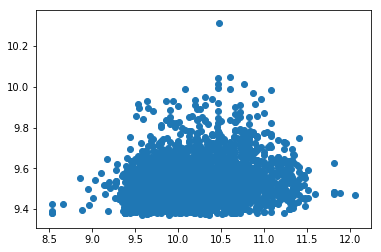

6252    0.790294
4684    1.168380
1731    0.147744
4742    0.371772
4521   -0.151696
6340    1.765800
576     0.830386
5202    1.267416
6363    0.897895
439     0.074422
2750    1.238990
7487    0.070033
5272    1.084595
5653    0.885398
3999    0.101840
6033    0.269443
582     0.710396
9930    0.187304
7051    1.113232
8158    0.807129
9896    0.532890
2249    1.828600
4640    0.929108
9485    0.448715
4947    1.391478
9920    0.341418
1963    0.297459
8243    0.103397
6590    1.052091
8847    0.358596
          ...   
4304    0.793669
7445    1.368220
428    -0.160554
7068    0.487044
6364    0.566975
4215    0.537437
426     0.514394
2223    0.799817
100     1.099916
9244   -0.699317
3307    0.822642
2762    1.307178
5857    0.786290
4738    1.074111
7092    0.428440
9632    0.799690
3286    0.276605
7712    0.240726
7868    0.752383
6067    0.316063
9235    0.366803
3577   -0.181233
1465    0.575408
7675    0.099552
2234    0.587033
1744    0.727108
9754    0.335192
6094    0.1984

In [113]:
print_results(d)
# This model has degenerate to predicted the mean only

In [ ]:
# deep_columns = [
#  tf.contrib.layers.embedding_column(workclass, dimension=8),
#]

# Continue on from https://www.tensorflow.org/versions/r0.10/tutorials/wide_and_deep/index.html